# Getty Images Data Crawling by Age

Notebook này sẽ crawl dữ liệu từ Getty Images dựa trên từ khóa độ tuổi, lưu ảnh theo format `age_id` và tạo DataFrame chứa filepath và age.

## 1. Import Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
from pathlib import Path
import time
from urllib.parse import urlencode
import json
from PIL import Image
from io import BytesIO

## 2. Configuration

In [2]:
# Cấu hình
OUTPUT_DIR = 'data/getty_images_raw'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Danh sách độ tuổi để tìm kiếm (từ 2 đến 100 tuổi)
AGE_KEYWORDS = []
AGE_MAPPING = {}

# Tạo danh sách từ 1 đến 100 tuổi
for age in range(1, 101):
    keyword = f'{age} years old'
    
    AGE_KEYWORDS.append(keyword)
    AGE_MAPPING[keyword] = age

# Headers để giả lập browser
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://www.gettyimages.com/'
}

# Số lượng ảnh tối đa cho mỗi độ tuổi
MAX_IMAGES_PER_AGE = 500

# Số trang tối đa để crawl
MAX_PAGES = 15

# Hiển thị thông tin
print(f"Tổng số độ tuổi cần crawl: {len(AGE_KEYWORDS)}")
print(f"Từ {min(AGE_MAPPING.values())} tuổi đến {max(AGE_MAPPING.values())} tuổi")
print(f"Tổng số ảnh dự kiến: {len(AGE_KEYWORDS) * MAX_IMAGES_PER_AGE} ảnh")

Tổng số độ tuổi cần crawl: 100
Từ 1 tuổi đến 100 tuổi
Tổng số ảnh dự kiến: 50000 ảnh


## 3. Functions để crawl Getty Images

In [3]:
def search_getty_images(keyword, num_images=500, max_pages=15):
    """
    Tìm kiếm ảnh trên Getty Images theo từ khóa với phân trang
    
    Args:
        keyword: Từ khóa tìm kiếm (ví dụ: '25 years old')
        num_images: Số lượng ảnh cần lấy
        max_pages: Số trang tối đa để crawl
    
    Returns:
        List các URL ảnh
    """
    session = requests.Session()
    image_urls = []
    
    print(f"Đang tìm kiếm: {keyword}...")
    
    # Duyệt qua các trang
    for page in range(1, max_pages + 1):
        if len(image_urls) >= num_images:
            break
            
        # Getty Images search URL với phân trang
        if page == 1:
            search_url = f'https://www.gettyimages.com/photos/{keyword.replace(" ", "-")}'
        else:
            search_url = f'https://www.gettyimages.com/photos/{keyword.replace(" ", "-")}?page={page}'
        
        try:
            print(f"  Đang crawl trang {page}/{max_pages}...")
            response = session.get(search_url, headers=HEADERS, timeout=10)
            
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                
                # Tìm các thẻ img (Getty Images có thể thay đổi cấu trúc HTML)
                images = soup.find_all('img', class_='MuiCardMedia-img')
                
                # Nếu không tìm thấy với class trên, thử các cách khác
                if not images:
                    images = soup.find_all('img', {'data-testid': 'gallery-image'})
                
                if not images:
                    # Lấy tất cả img tags và filter
                    all_images = soup.find_all('img')
                    images = [img for img in all_images if img.get('src') and 'getty' in img.get('src', '').lower()]
                
                page_count = 0
                for img in images:
                    if len(image_urls) >= num_images:
                        break
                    
                    src = img.get('src') or img.get('data-src')
                    if src and src.startswith('http') and src not in image_urls:
                        image_urls.append(src)
                        page_count += 1
                
                print(f"    Tìm thấy {page_count} ảnh mới từ trang {page} (Tổng: {len(image_urls)}/{num_images})")
                
                # Nếu không tìm thấy ảnh nào, dừng việc phân trang
                if page_count == 0:
                    print(f"    Không còn ảnh mới, dừng tại trang {page}")
                    break
            else:
                print(f"  Lỗi khi tải trang {page}: {response.status_code}")
                break
        
        except Exception as e:
            print(f"  Lỗi khi crawl trang {page}: {str(e)}")
            break
        
        # Delay giữa các trang để tránh bị block
        time.sleep(2)
    
    print(f"Tổng cộng tìm thấy {len(image_urls)} ảnh cho '{keyword}'")
    time.sleep(1)
    return image_urls[:num_images]  # Giới hạn số lượng ảnh trả về


def download_image(url, filepath):
    """
    Download ảnh từ URL và lưu vào filepath
    
    Args:
        url: URL của ảnh
        filepath: Đường dẫn để lưu ảnh
    
    Returns:
        True nếu thành công, False nếu thất bại
    """
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        if response.status_code == 200:
            # Mở và lưu ảnh
            img = Image.open(BytesIO(response.content))
            # Convert sang RGB nếu cần
            if img.mode in ('RGBA', 'P'):
                img = img.convert('RGB')
            img.save(filepath)
            return True
        else:
            print(f"Không thể tải ảnh: {response.status_code}")
            return False
    except Exception as e:
        print(f"Lỗi khi tải ảnh từ {url}: {str(e)}")
        return False

## 4. Crawl dữ liệu từ Getty Images

In [ ]:
# Danh sách để lưu thông tin ảnh
data_list = []

# Duyệt qua từng độ tuổi
for keyword in AGE_KEYWORDS:
    age = AGE_MAPPING[keyword]
    print(f"\n{'='*60}")
    print(f"Đang crawl dữ liệu cho độ tuổi: {age} ({keyword})")
    print(f"{'='*60}")
    
    # Tạo thư mục cho độ tuổi này
    age_dir = os.path.join(OUTPUT_DIR, f'{age:03d}')
    os.makedirs(age_dir, exist_ok=True)
    
    # Tìm kiếm ảnh với phân trang
    image_urls = search_getty_images(keyword, MAX_IMAGES_PER_AGE, MAX_PAGES)
    
    # Download từng ảnh
    success_count = 0
    for idx, url in enumerate(image_urls, start=1):
        # Format filename: age_id (ví dụ: 25_001.jpg)
        filename = f'{age:03d}_{idx:03d}.jpg'
        filepath = os.path.join(age_dir, filename)
        relative_path = os.path.join('data', 'getty_images_raw', f'{age:03d}', filename)
        
        # Download ảnh
        if download_image(url, filepath):
            data_list.append({
                'filepath': relative_path,
                'age': age
            })
            success_count += 1
            print(f"✓ Đã lưu: {filename} ({success_count}/{len(image_urls)})")
        else:
            print(f"✗ Lỗi khi lưu: {filename}")
        
        # Delay để tránh bị block
        # time.sleep(1)
    
    print(f"\nHoàn thành độ tuổi {age}: {success_count}/{len(image_urls)} ảnh thành công")

print(f"\n{'='*60}")
print(f"HOÀN THÀNH! Tổng số ảnh đã tải: {len(data_list)}")
print(f"{'='*60}")


Đang crawl dữ liệu cho độ tuổi: 1 (1 years old)
Đang tìm kiếm: 1 years old...
  Đang crawl trang 1/15...
    Tìm thấy 60 ảnh mới từ trang 1 (Tổng: 60/500)
    Tìm thấy 60 ảnh mới từ trang 1 (Tổng: 60/500)
  Đang crawl trang 2/15...
  Đang crawl trang 2/15...
    Tìm thấy 60 ảnh mới từ trang 2 (Tổng: 120/500)
    Tìm thấy 60 ảnh mới từ trang 2 (Tổng: 120/500)
  Đang crawl trang 3/15...
  Đang crawl trang 3/15...
    Tìm thấy 60 ảnh mới từ trang 3 (Tổng: 180/500)
    Tìm thấy 60 ảnh mới từ trang 3 (Tổng: 180/500)
  Đang crawl trang 4/15...
  Đang crawl trang 4/15...
    Tìm thấy 60 ảnh mới từ trang 4 (Tổng: 240/500)
    Tìm thấy 60 ảnh mới từ trang 4 (Tổng: 240/500)
  Đang crawl trang 5/15...
  Đang crawl trang 5/15...
    Tìm thấy 60 ảnh mới từ trang 5 (Tổng: 300/500)
    Tìm thấy 60 ảnh mới từ trang 5 (Tổng: 300/500)
  Đang crawl trang 6/15...
  Đang crawl trang 6/15...
    Tìm thấy 60 ảnh mới từ trang 6 (Tổng: 360/500)
    Tìm thấy 60 ảnh mới từ trang 6 (Tổng: 360/500)
  Đang crawl t

## 5. Tạo DataFrame và lưu kết quả

In [5]:
# Tạo DataFrame từ danh sách
df = pd.DataFrame(data_list)

# Hiển thị thông tin DataFrame
print("Thông tin DataFrame:")
print(f"Số lượng ảnh: {len(df)}")
print(f"\nPhân bố theo độ tuổi:")
print(df['age'].value_counts().sort_index())
print(f"\nMẫu dữ liệu:")
print(df.head(10))

# Lưu DataFrame vào CSV
csv_path = os.path.join(OUTPUT_DIR, 'getty_images_dataset.csv')
df.to_csv(csv_path, index=False)
print(f"\n✓ Đã lưu DataFrame vào: {csv_path}")

Thông tin DataFrame:
Số lượng ảnh: 50000

Phân bố theo độ tuổi:
age
1      500
2      500
3      500
4      500
5      500
      ... 
96     500
97     500
98     500
99     500
100    500
Name: count, Length: 100, dtype: int64

Mẫu dữ liệu:
                            filepath  age
0  data\getty_images\001\001_001.jpg    1
1  data\getty_images\001\001_002.jpg    1
2  data\getty_images\001\001_003.jpg    1
3  data\getty_images\001\001_004.jpg    1
4  data\getty_images\001\001_005.jpg    1
5  data\getty_images\001\001_006.jpg    1
6  data\getty_images\001\001_007.jpg    1
7  data\getty_images\001\001_008.jpg    1
8  data\getty_images\001\001_009.jpg    1
9  data\getty_images\001\001_010.jpg    1

✓ Đã lưu DataFrame vào: data/getty_images_raw\getty_images_dataset.csv


## 7. Xem mẫu ảnh đã tải

Hiển thị ảnh cho độ tuổi 10: data\getty_images\010\010_001.jpg
Hiển thị ảnh cho độ tuổi 20: data\getty_images\020\020_001.jpg
Hiển thị ảnh cho độ tuổi 30: data\getty_images\030\030_001.jpg
Hiển thị ảnh cho độ tuổi 40: data\getty_images\040\040_001.jpg
Hiển thị ảnh cho độ tuổi 50: data\getty_images\050\050_001.jpg
Hiển thị ảnh cho độ tuổi 60: data\getty_images\060\060_001.jpg
Hiển thị ảnh cho độ tuổi 70: data\getty_images\070\070_001.jpg
Hiển thị ảnh cho độ tuổi 80: data\getty_images\080\080_001.jpg
Hiển thị ảnh cho độ tuổi 92: data\getty_images\092\092_001.jpg
Hiển thị ảnh cho độ tuổi 100: data\getty_images\100\100_001.jpg


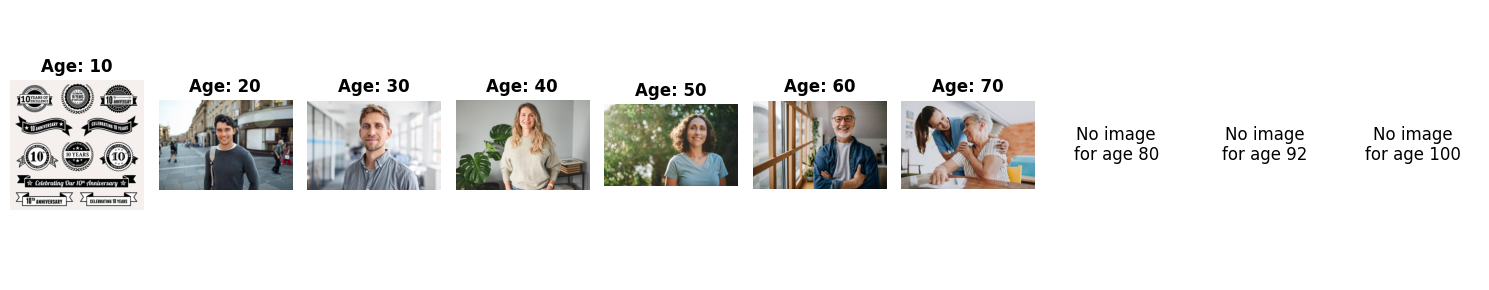


✓ Đã lưu mẫu ảnh vào: data/getty_images/sample_images.png


In [9]:
import matplotlib.pyplot as plt

# Hiển thị mẫu ảnh từ các độ tuổi khác nhau
sample_ages = [10, 20,30, 40, 50, 60, 70,80,92,100]
fig, axes = plt.subplots(1, len(sample_ages), figsize=(15, 3))

for idx, age in enumerate(sample_ages):
    # Lấy ảnh đầu tiên của độ tuổi này
    age_images = df[df['age'] == age]
    
    if len(age_images) > 0:
        img_path = age_images.iloc[0]['filepath']
        print(f"Hiển thị ảnh cho độ tuổi {age}: {img_path}")
        # Kiểm tra xem file có tồn tại không
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f'Age: {age}', fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f'No image\nfor age {age}', 
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f'No data\nfor age {age}', 
                      ha='center', va='center', fontsize=12)
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sample_images.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Đã lưu mẫu ảnh vào: data/getty_images/sample_images.png")

## 8. Tóm tắt kết quả

**Kết quả crawl dữ liệu:**
- Dữ liệu được lưu trong thư mục: `data/getty_images/`
- Cấu trúc: Mỗi độ tuổi có thư mục riêng (001, 002, ..., 080)
- Format tên file: `age_id.jpg` (ví dụ: `025_001.jpg` cho ảnh đầu tiên của độ tuổi 25)
- DataFrame được lưu trong file: `getty_images_dataset.csv` với 2 cột:
  - `filepath`: Đường dẫn đến file ảnh
  - `age`: Độ tuổi tương ứng

**Lưu ý:**
- Getty Images có thể yêu cầu xác thực hoặc có biện pháp chống crawl
- Nếu không tải được ảnh, có thể cần:
  1. Sử dụng Selenium để render JavaScript
  2. Đăng nhập vào Getty Images
  3. Sử dụng API chính thức của Getty Images (có tính phí)
- Thay vào đó, bạn có thể sử dụng các nguồn khác như Unsplash, Pexels, hoặc các dataset công khai